For the data:  https://www.kaggle.com/thulasikumar7/logistic-regression-amazon-fine-food-reviews/data

In [59]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import sqlite3 as sql
sns.set()


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
import seaborn as sns

In [60]:
con = sql.connect('database.sqlite')
filtered_data = pd.read_sql_query("""select * from reviews limit 10000""",con)
score = filtered_data['Score'].map(lambda x: 0 if x> 3 else 1)

In [61]:
filtered_data['Score']=score
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [62]:
display = pd.read_sql_query(""" SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1 """, con)
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


## EDA

In [63]:
display= pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID """, con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [64]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [65]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep ='first', inplace=False)
final.shape

(9515, 10)

In [66]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.15

In [67]:
display= pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID """, con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [68]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

(9515, 10)
0    7285
1    2230
Name: Score, dtype: int64


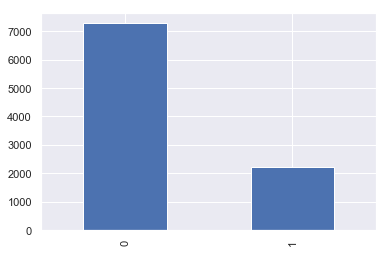

In [69]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())
final['Score'].value_counts().plot(kind='bar')

## Pre-processing

In [70]:
final['Time']=pd.to_datetime(final['Time'],unit='s')
final=final.sort_values(by='Time')
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,0,2000-06-23,Great Product,This was a really good idea and the final prod...
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,0,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
8110,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,0,2004-01-30,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...
3782,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,0,2004-04-10,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...
7431,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,0,2004-05-02,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...


In [71]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900) 
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [72]:
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)
sent_1000 = final['Text'].values[1000]
print(sent_1000) 
print("="*50)
sent_1500 = final['Text'].values[1500]
print(sent_1500) 
print("="*50)
sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
This is really the way to go. Add some creamer to further enhance the flavor of this blend. I signed up for a subscription to have this delivered every month. I drink some every morning at work. Works great with the B&D Home Cafe system.
I was born in Argentina and this is a top of the line dulce de leche, to eat with toasts or as add-on to cakes (comparable to Chimbote).<br /><br />Note: I noticed that dulce de leche is an acquired taste. So unless you grew up eating it, you may consider dulce de leche to be a little too sweet.
I'm very happy with this product. It was less expensive here than at my local Whole Foods and having purchased other Navitas items, I can say that it is quickly becoming a favorite brand.


In [73]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(sent_0, 'lxml') 
text = soup.get_text() 
print(text) 
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml') 
text = soup.get_text() 
print(text) 
print("="*50) 

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50) 

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
This is really the way to go. Add some creamer to further enhance the flavor of this blend. I signed up for a subscription to have this delivered every month. I drink some every morning at work. Works great with the B&D Home Cafe system.
I was born in Argentina and this is a top of the line dulce de leche, to eat with toasts or as add-on to cakes (comparable to Chimbote).Note: I noticed that dulce de leche is an acquired taste. So unless you grew up eating it, you may consider dulce de leche to be a little too sweet.
I'm very happy with this product. It was less expensive here than at my local Whole Foods and having purchased other Navitas items, I can say that it is quickly becoming a favorite brand.


In [74]:
import re
def decontracted(phrase): 
     # specific 
    phrase = re.sub(r"won't", "will not", phrase) 
    phrase = re.sub(r"can\'t", "can not", phrase) 
    # general 
    phrase = re.sub(r"n\'t", " not", phrase) 
    phrase = re.sub(r"\'re", " are", phrase)  
    phrase = re.sub(r"\'s", " is", phrase)   
    phrase = re.sub(r"\'d", " would", phrase) 
    phrase = re.sub(r"\'ll", " will", phrase)  
    phrase = re.sub(r"\'t", " not", phrase)   
    phrase = re.sub(r"\'ve", " have", phrase)  
    phrase = re.sub(r"\'m", " am", phrase)   
    return phrase



In [75]:
sent_1500 = decontracted(sent_1500) 
print(sent_1500)
print("="*50)

I was born in Argentina and this is a top of the line dulce de leche, to eat with toasts or as add-on to cakes (comparable to Chimbote).<br /><br />Note: I noticed that dulce de leche is an acquired taste. So unless you grew up eating it, you may consider dulce de leche to be a little too sweet.


In [76]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [77]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I was born in Argentina and this is a top of the line dulce de leche to eat with toasts or as add on to cakes comparable to Chimbote br br Note I noticed that dulce de leche is an acquired taste So unless you grew up eating it you may consider dulce de leche to be a little too sweet 


In [78]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [79]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9515/9515 [00:11<00:00, 858.92it/s] 


In [80]:
final ['preprocessed_reviews']= preprocessed_reviews

## Stored in Sqlite table for future use

In [81]:
conn = sql.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
#Loading data
conn = sql.connect('final.sqlite')
data=pd.read_sql_query("""select * from Reviews""",conn)

## Splitting in train and test data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(final ['preprocessed_reviews'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (4271,) (4271,)
CV: (2104,) (2104,)
Test: (3140,) (3140,)


In [83]:
def optimal_lamda(X_train,y_train,X_cv,y_cv):
    train_auc_l1 = [] 
    train_auc_l2 = [] 
    cv_auc_l1 = []
    cv_auc_l2 = []
    penalty=['l1','l2']
    hyper_param=[10**i for i in range(-5,5)]
    for i in penalty:
        for j in  hyper_param:
            clf = LogisticRegression(C=j, penalty= i)
            clf.fit(X_train, y_train)
            y_train_pred =  clf.predict_proba(X_train)[:,1] 
            y_cv_pred =  clf.predict_proba(X_cv)[:,1]
            if i == 'l1':
                train_auc_l1.append(roc_auc_score(y_train,y_train_pred)) 
                cv_auc_l1.append(roc_auc_score(y_cv, y_cv_pred))
            else:
                train_auc_l2.append(roc_auc_score(y_train,y_train_pred))
                cv_auc_l2.append(roc_auc_score(y_cv, y_cv_pred))
    #Error plots with penaly L1
    plt.plot(np.log(hyper_param), train_auc_l1, label='Train AUC-L1') 
    plt.plot(np.log(hyper_param), cv_auc_l1, label='CV AUC-L1')
    plt.legend()
    plt.xlabel("Lamda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    #Error plots with penaly L2
    plt.plot(np.log(hyper_param), train_auc_l2, label='Train AUC-L2') 
    plt.plot(np.log(hyper_param), cv_auc_l2, label='CV AUC-L2')
    plt.legend()
    plt.xlabel("Lamda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    #Cv auc scores with penalty L1
    print("Cv auc scores with penalty L1")
    print(cv_auc_l1)
    print("Maximun Auc value :",max(cv_auc_l1))
    print("Index",cv_auc_l1.index(max(cv_auc_l1)))
    #Cv auc scores with penalty L2
    print("--------------------------")
    print("Cv auc scores with penalty L2")
    print(cv_auc_l2)
    print("Maximun Auc value :",max(cv_auc_l2))
    print("Index",cv_auc_l2.index(max(cv_auc_l2)))

In [84]:
## function for getting important features
def top_features(vectorizer, clf, n):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## Featurization

 Bag of Words

In [85]:
## applying count vectorizer and stanardizing it


vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 

print("*************************")
print("Standardization")
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_cv_bow=StandardScaler(with_mean=False).fit_transform(X_cv_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 

After vectorizations
(4271, 126449) (4271,)
(2104, 126449) (2104,)
(3140, 126449) (3140,)
*************************
Standardization
(4271, 126449) (4271,)
(2104, 126449) (2104,)
(3140, 126449) (3140,)


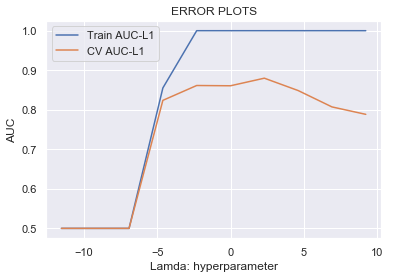

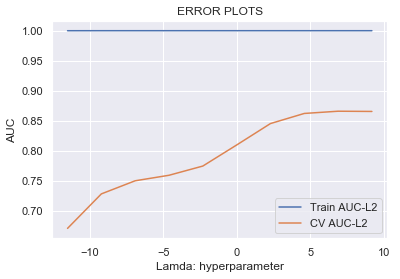

Cv auc scores with penalty L1
[0.5, 0.5, 0.5, 0.8238177376845444, 0.8613721099659303, 0.8606864299642161, 0.879880782746577, 0.8486127032934069, 0.8072194604555486, 0.7884034369710087]
Maximun Auc value : 0.879880782746577
Index 6
--------------------------
Cv auc scores with penalty L2
[0.6702093466755233, 0.727736827444342, 0.7496223403115558, 0.7587919711157299, 0.7741742377166855, 0.8092965887419914, 0.8450590863313978, 0.8619305641860764, 0.8656683237266707, 0.8652893248194733]
Maximun Auc value : 0.8656683237266707
Index 8


In [86]:
optimal_lamda(X_train_bow,y_train,X_cv_bow,y_cv)

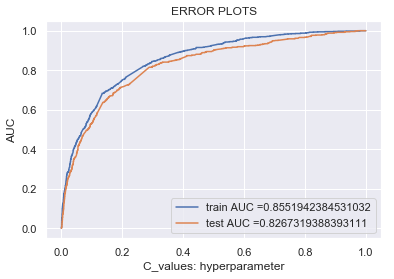

In [87]:
#Testing with test data
clf = LogisticRegression(penalty='l1',C=0.01)
clf.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1]) 
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("C_values: hyperparameter") 
plt.ylabel("AUC") 
plt.title("ERROR PLOTS") 
plt.show() 

## Confusion matrix

Train confusion matrix
[[3179   44]
 [ 819  229]]
Test confusion matrix
[[2365   45]
 [ 564  166]]


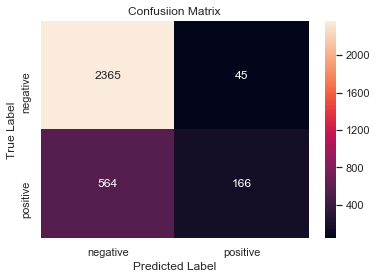

In [88]:
from sklearn.metrics import confusion_matrix 
print("Train confusion matrix") 
print(confusion_matrix(y_train, clf.predict(X_train_bow))) 
print("Test confusion matrix")
print(confusion_matrix(y_test, clf.predict(X_test_bow)))
cm_test=confusion_matrix(y_test, clf.predict(X_test_bow))
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [89]:
##Important features from positive and negative classes
top_features(vectorizer, clf,10
            )

				Negative						Positive
________________________________________________________________________________________________
	-0.3839	not            				0.2651	great          
	-0.1923	not buy        				0.1218	delicious      
	-0.1530	ok             				0.1081	love           
	-0.1173	bad            				0.0918	best           
	-0.0982	disappointed   				0.0867	good           
	-0.0870	thought        				0.0786	excellent      
	-0.0865	not worth      				0.0752	highly         
	-0.0718	refund         				0.0590	perfect        
	-0.0596	awful          				0.0580	nice           
	-0.0586	disappointing  				0.0525	smooth         


In [90]:
## Perbutation test
#Weights before adding noise
weights1=clf.coef_
print(weights1.shape)

(1, 126449)


In [91]:
import copy
Noise_data=copy.deepcopy(X_train_bow)
e=np.random.normal(0,0.001)
Noise_data.data += e
print(Noise_data.shape)

(4271, 126449)


In [92]:
#Calculating weights after adding noise
model = LogisticRegression(C= 0.01, penalty= 'l1')
model.fit(Noise_data,y_train)
weights2=model.coef_
print(weights2.shape)

(1, 126449)


In [93]:
#Adding small noise to avoid zero divide error
e=np.random.normal(0,0.001)
weights1+=e
weights2+=e

In [94]:
weights_difference = np.abs((weights2-weights1)/weights1)*100
#print(weights_difference)
print(weights_difference.max())
print(weights_difference.min())
print(weights_difference.std())

2.00433503499916
0.0
0.00959962253408993


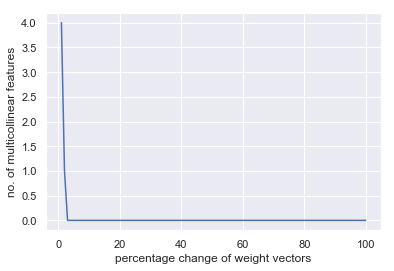

In [95]:
percentage_change=[]
collinear_features=[]

for i in range(1,101):
    f=np.where(weights_difference > i)[1].size
    percentage_change.append(i)
    collinear_features.append(f)
    
plt.xlabel('percentage change of weight vectors')
plt.ylabel('no. of multicollinear features')
plt.plot(percentage_change,collinear_features)

In [96]:
feat = vectorizer.get_feature_names()
print("No of features have weight changes greater than 30%: ", weights_difference[np.where(weights_difference > 30)].size)
fe=[]
print("\nHence below features are collinear:")
for i in np.where(weights_difference > 1)[1]:
    fe.append(feat[i])
print(fe)

No of features have weight changes greater than 30%:  0

Hence below features are collinear:
['flat', 'nothing', 'orange', 'unfortunately']
